## Neural Differential Equation

Instead of using any control algorithm or reinforcement learning, the task of controlling an inverted pendulum can be solved by making use of a neural network (NN). One such approach is Hybrid Scientific Machine Learning (SciML), which defines learnable components of a pipeline and uses NNs in order to learn those. Here, instead we will expand our mathematical problem into a Neural Differential Equation (NDE), which is another approach.

The key idea of NDEs is to use NNs to represent parts of a differential equation, or in this case here a system of differential equations, which we don't have any information about. We then solve the problem, in the case of ordinary differential equations (ODEs) with a commonly used numerical method, such as the Euler method or even higher order Runge Kutta methods. This problem then describes a hybrid simulation workflow.
<!-- ![alt text](visualizations/inverted_pendulum_problem.png "Title") -->
<!-- <h4>Cart Pole Visualization</h4> -->
#### Inverted Pendulum Problem Setup ####
The following image describes the problems setup and the goal to balance the pendulum at $\theta(t>0.75t_N)$. The pendulum has the following properties. a length $\textit{l}$, mass $\textit{m}$ attached to a cart of mass $\textit{M}$. Furthermore, $\textit{x(t)}$ is the horizontal position of the cart and $\theta\textit{(t)}$ is the deflection from the vertical of the pendulum. The equations of motion are derived from Newton's second law and are given as:

$$
\ddot{x} = \frac{F - m g cos(\theta) sin(\theta) + m l \dot{\theta}^2 sin(\theta)}{M + m - m cos^2(\theta)}
$$

$$
\ddot{\theta} = \frac{g sin(\theta) \ddot{x} cos(\theta)}{l}
$$


<img src="visualizations/inverted_pendulum_problem.png" alt="training_evaluation" style="width:200px;"/>

In a first task, given some initial conditions, we can solve this problem by utilizing a numerical method, in our case a Runge Kutta fourth order method. For this we first need to rewrite the two second order ODEs into four first order ODEs. Thus the eproblem can be rewritten as follows, where the states of the dynamical system can be described as $x_1 = x$, $x_2 = \dot{x}$, $x_3 = \theta$ and $x_4 = \dot{\theta}$.

$$
\begin{pmatrix}
    \dot{x}_1\\[0.5em]
    \dot{x}_2\\[0.5em]
    \dot{x}_3\\[0.5em]
    \dot{x}_4
\end{pmatrix}
= 
\begin{pmatrix}
    x_2\\[0.5em]
    \frac{F - m g cos(\theta) sin(\theta) + m l \dot{\theta}^2 sin(\theta)}{M + m - m cos^2(\theta)}\\[0.5em]
    x_4\\[0.5em]
    \frac{g sin(\theta) cos(\theta)}{l} \cdot \frac{F - m g cos(\theta) sin(\theta) + m l \dot{\theta}^2 sin(\theta)}{M + m - m cos^2(\theta)}
\end{pmatrix}
$$

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from inverted_pendulum import Inverted_Pendulum
from util import create_video, create_individual_summary, create_summary, create_trainings_gif, solver_comparison
import os

In [2]:
# Setup for the Simulation
t0 = 0
tN = 5
N = 100
dt = (tN-t0)/(N-1)
# Initial Conditions
x0 = (0.0, 0.0, jnp.pi/4, 0.0) # (x, d_x, theta, d_theta)
# Problem Parameters
args = (0.1, 9.81, 1.0, 1.0) # (m, g, l, M)
# Simulation Time
t = jnp.linspace(t0, tN, N)

pendulum = Inverted_Pendulum(t0, tN, N, dt, x0, args)

## Solver Evluation

Since JAX is in their own documentation described as a library for array-oriented numerical computation with automatic differentiation and just in time (JIT) compilation to enable high-performance machine learning research, we will make use of it. Here, in this first section there is an analysis of a hardcoded RK solver in comparison to a built in JAX-based RK solver from the Diffrax library, to solve the described problem given some initial conditions x0 and a force expressed as follows.

$$
F(t) = 10 \cdot sin(t)
$$

When testing diffrax against my implementation it could be seen that in the beginning diffrax is way slower than my solver, thus for the following anlysis I did a few warmup rounds to overcome this effect. In the provided image afterwards it could be seen that the hardcoded implementation gives back the correct results but is a bit slower than the optimized diffrax solver.

Diffrax took 0.14004608640007063 
Hardcoded RK4 took 0.32564113880002876
The built in diffrax method is 56.993736443701984% faster than the hardcoded fourth order Runge Kutta method


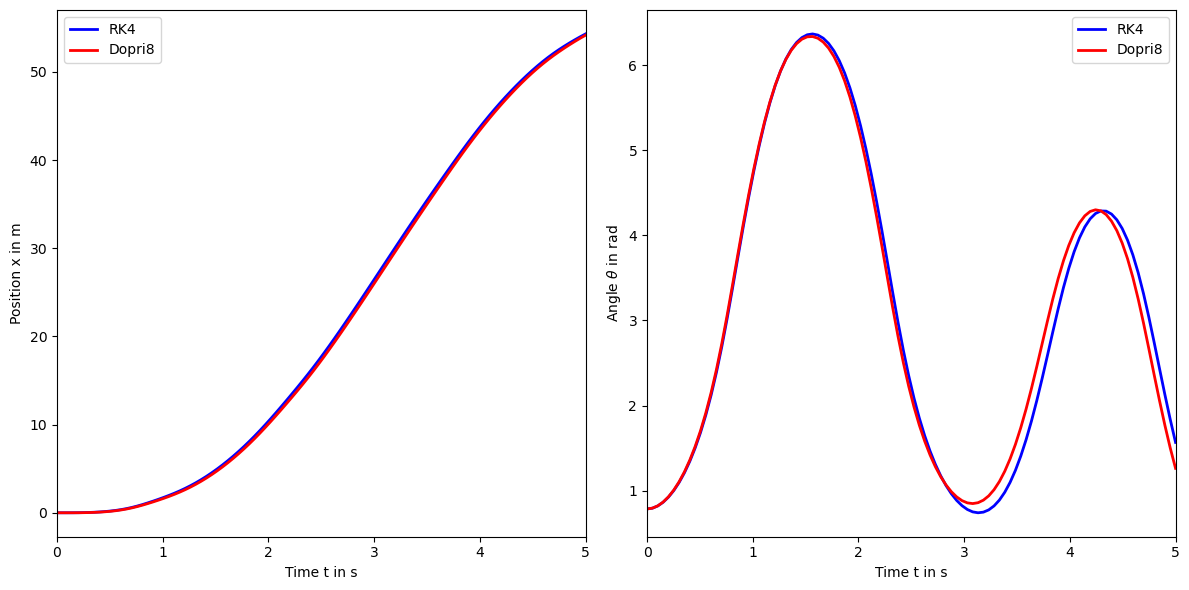

In [3]:
times_diffrax = []
times_rk4 = []
warmup_rounds = 5
for i in range(10):
    if i == 0:
        # Do some warmup rounds:
        for warmup in range(warmup_rounds):
            _, _ = pendulum.test_method('diffrax')
            _, _ = pendulum.test_method('RK4')
    _, time_diffrax = pendulum.test_method("diffrax")
    times_diffrax.append(time_diffrax)
    _, time_rk4 = pendulum.test_method("RK4")
    times_rk4.append(time_rk4)

avg_time_diffrax = np.mean(times_diffrax)
avg_time_rk4 = np.mean(times_rk4)

print(f"Diffrax took {avg_time_diffrax} \nHardcoded RK4 took {avg_time_rk4}")
# Compute how much faster diffrax is in comparison to the hardcoded version is
speedup = 100 * (avg_time_rk4 - avg_time_diffrax) / avg_time_rk4
print(f"The built in diffrax method is {speedup}% faster than the hardcoded fourth order Runge Kutta method")

sol_diffrax = pendulum.diffrax_solver()
sol_rk4 = pendulum.ode_solver()
solver_comparison(sol_rk4, sol_diffrax, t, save=False)

## Neural Differential Equation (NDE)

Now we want to control the pendulum by adjusting the Force F such that for all times $t > 0.75 t_N$ the angular deflection of the pendulum is near zero $\theta \approx 0$. We can achieve this by replacing the force F with a NN and do a forward simulation before we update the weights $\phi$ of the NN. Thus, by replacing F with $NN(t;\phi)$, which takes only the time t as an input, the ODE system can be rewritten as follows.

$$
\begin{pmatrix}
    \dot{x}_1\\[0.5em]
    \dot{x}_2\\[0.5em]
    \dot{x}_3\\[0.5em]
    \dot{x}_4
\end{pmatrix}
= 
\begin{pmatrix}
    x_2\\[0.5em]
    \frac{NN(t;\phi) - m g cos(\theta) sin(\theta) + m l \dot{\theta}^2 sin(\theta)}{M + m - m cos^2(\theta)}\\[0.5em]
    x_4\\[0.5em]
    \frac{g sin(\theta) cos(\theta)}{l} \cdot \frac{NN(t;\phi) - m g cos(\theta) sin(\theta) + m l \dot{\theta}^2 sin(\theta)}{M + m - m cos^2(\theta)}
\end{pmatrix}
$$

The following gif visualizes the training process and how the force F gets updated to reach the goal of an angular deflection near zero. Through severa trials I also incorporated a punishment of the angular velocity after $t > 0.75 t_N$, to reach even better results.

<!-- ![training_eval](visualizations/training_eval.gif) -->
<img src="visualizations/training_eval.gif" alt="training_evaluation" style="width:400px;"/>

It can be seen that the force F is not as smooth as expected, through further physical constraints we could furthermore get rid of this piecewise linear behavior of the force in some parts of the control loop.

[1/2000] loss: 25.507535934448242
[500/2000] loss: 0.2734643816947937
[1000/2000] loss: 0.15573656558990479
[1500/2000] loss: 0.0777565985918045
[2000/2000] loss: 0.06337544322013855


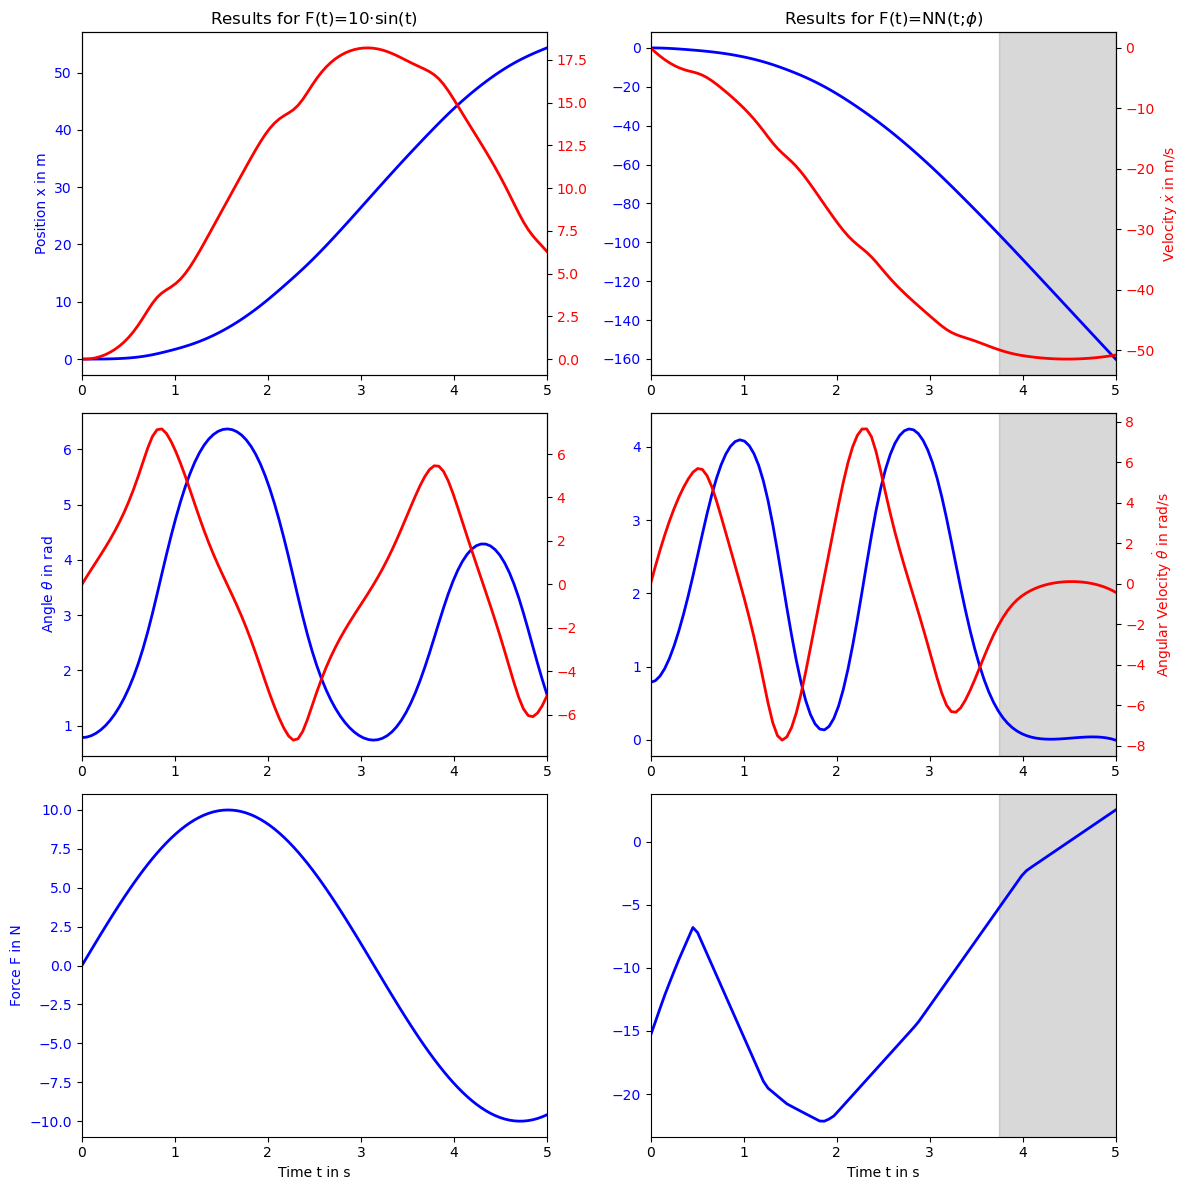

In [4]:
epochs = 2000
# You can choose between the following two solvers
# solver = 'RK4'
# solver = 'diffrax'
pendulum.train(epochs)

x_model = pendulum.ode_solver(pendulum.model, nde=True)
create_summary(t, sol_rk4, x_model, pendulum.model, save=False)

## Animation of the Polecart

For a further analysis I added an animation of the polecart which can be seen in this section. The following code parts can be uncommented to recreate the animation. Also further visualization tools can be found in util.py.

<!-- ![pole_cart_visualization](visualizations/cart_pole_animation.gif) -->
<img src="visualizations/cart_pole_animation.gif" alt="pole_cart_visualization" style="width:400px;"/>

In [5]:
# Uncomment to play or store the gif shown in the description above
# create_video(x=x_model, dt=dt, N=N, save=False)

# Steps to create the trainings gif shown above can be done by uncommenting the following code
# os.makedirs('video')
# pendulum.train(epochs, video=True)
# create_trainings_gif('video')

# Also in utils.py there are more options to create plots